In [1]:
import pandas as pd
import numpy as np
import os
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def build_data_frame(data_directory:str) -> Tuple[pd.DataFrame, pd.DataFrame]:  
    """Build a data frame given a data directory
    
    Returns two dataframes
    """

    dataframes = []

    row_count = 0

    for dirpath, dirs, files in os.walk(data_directory):
        for n, file in enumerate(files):
            df = pd.read_csv(os.path.join(dirpath,file))
            df = df.drop('Player-additional', axis=1)
            df['Year'] = 2020 + n + 1
            if 'MP▼' in df.columns:
                df.rename(columns={'MP▼':'MP'}, inplace=True)

            if 'Team' in df.columns:
                df.rename(columns={'Team':'Tm'}, inplace=True) 

            dataframes.append(df)
            row_count += df.shape[0]

    nba_df = pd.concat(dataframes)

    #select columns of interest
    nba_totals = nba_df[['Player', 'Tm','Pos', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', '3P',
       '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year']].copy()
    
    #drop the total rows to avoid double counting
    nba_totals = nba_totals[~(nba_totals['Tm'] == 'TOT') & ~(nba_totals['Tm'] == '2TM') & ~(nba_totals['Tm'] == '3TM')].copy()

    # if the data type is numeric return the sum if the data type is not then return the mode (Pos, Tm)
    def smart_agg(x):
        if np.issubdtype(x.dtype, np.number):
            return x.sum()
        else:
            return x.mode()[0]  # or .mode()[0], .unique(), etc.

    nba_totals_agg = nba_totals.groupby(['Player', 'Age', 'Year']).agg(lambda x: smart_agg(x)).reset_index()


    return nba_df, nba_totals_agg

In [3]:
df_totals, df_aggregated = build_data_frame(r"..\data_files")

In [4]:
#remove players with less than 50 games
df50 = df_aggregated[df_aggregated['G'] >=50].copy()

#select dtypes = numeric
df50_numeric = df50.select_dtypes('number').drop(columns=['Age', 'Year'])

In [5]:
df50.columns

Index(['Player', 'Age', 'Year', 'Tm', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA',
       '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

## Correlation Heat Map for Key Statistics

Minutes per game has a strong positive correlation with key statistics such as Field Goals and Points. This is an expected outcome. Players that play more generally shoot more and score more. There is a perfect positive correlation of 1 with FG and Points. This is also expected. Field Goals represents the actual makes of the player, not just attempts. For a given player, making more field goals correlates perfectly to more points.

Total rebounds and blocks also has a strong positive correlation of .6. There are two mediating variables here, height and player location. As taller player is generally able to get more rebounds and block more shots. Taller players often play closer to the rim and have a higher probabilty of reaching rebounds. They also defend the rim due to their height, leading to more blocks. 

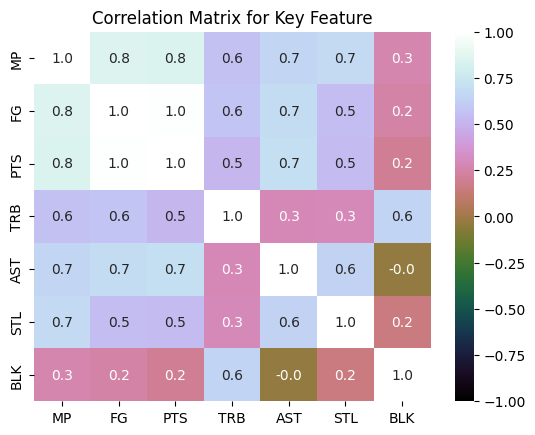

In [6]:
#corrleation matrix to help show relationship between variables
sns.heatmap(df50_numeric[['MP', 'FG', 'PTS', 'TRB', 'AST', 'STL', 'BLK']].corr(),annot=True, fmt=".1f", cmap = 'cubehelix', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Key Feature');

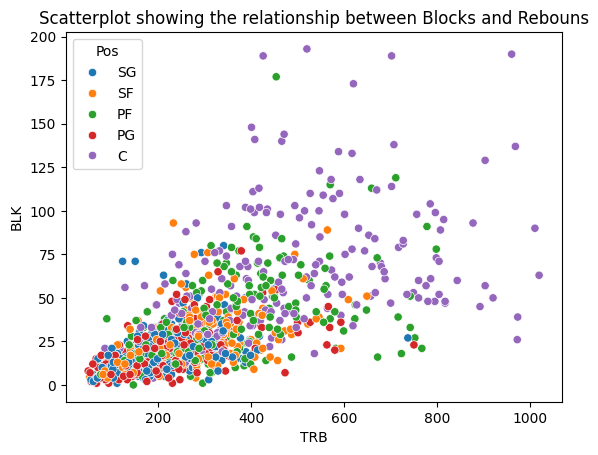

In [7]:
sns.scatterplot(data=df50, x='TRB', y='BLK', hue="Pos")
plt.title('Scatterplot showing the relationship between Blocks and Rebouns');

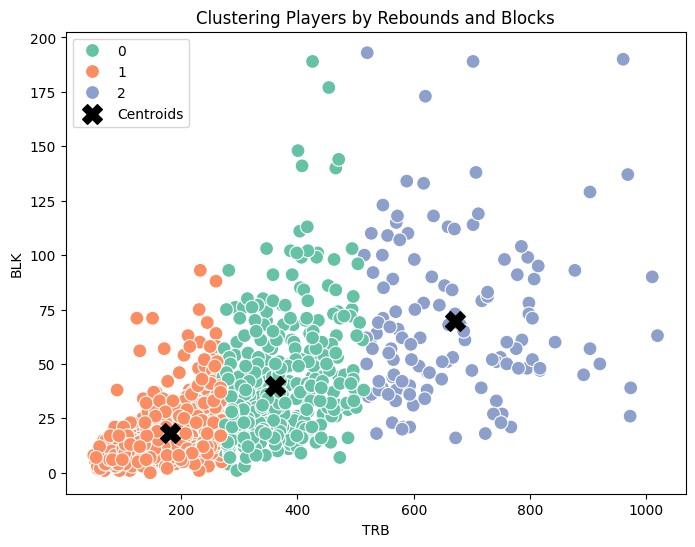

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select features
X = df50[['TRB', 'BLK']]

# Step 2: Fit KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df50['Cluster'] = kmeans.fit_predict(X)

# Step 3: Add cluster centers for visualization
centroids = kmeans.cluster_centers_

# Step 4: Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df50, x='TRB', y='BLK', hue='Cluster', palette='Set2', s=100)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, marker='X', label='Centroids')
plt.title("Clustering Players by Rebounds and Blocks")
plt.legend()
plt.show()


In [9]:
cluster_summary = df50.groupby('Cluster')[['TRB', 'BLK']].mean()
print(cluster_summary)

                TRB        BLK
Cluster                       
0        361.052764  39.866834
1        181.421311  18.336066
2        671.396825  69.626984


In [10]:
pd.crosstab(df50['Cluster'], df50['Pos'], normalize='index')

Pos,C,PF,PG,SF,SG
Cluster,,,,,
0,0.228643,0.263819,0.115578,0.231156,0.160804
1,0.057377,0.152459,0.262295,0.181967,0.345902
2,0.666667,0.214286,0.055556,0.055556,0.007937


In [11]:
cluster_percents = pd.crosstab(df50['Cluster'], df50['Pos'], normalize='index').reset_index()
cluster_percents

Pos,Cluster,C,PF,PG,SF,SG
0,0,0.228643,0.263819,0.115578,0.231156,0.160804
1,1,0.057377,0.152459,0.262295,0.181967,0.345902
2,2,0.666667,0.214286,0.055556,0.055556,0.007937


In [12]:
melted_cluster_percent = pd.melt(cluster_percents, id_vars='Cluster')

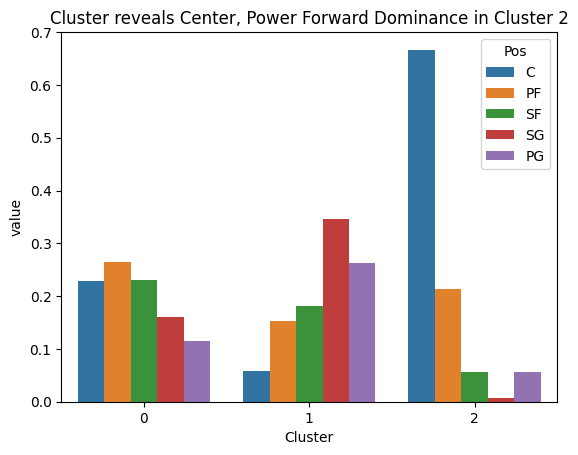

In [13]:
custom_pos_order = ['C', 'PF', 'SF', 'SG', 'PG']
sns.barplot(data=melted_cluster_percent, x='Cluster', y='value', hue='Pos', hue_order=custom_pos_order)
plt.title('Cluster reveals Center, Power Forward Dominance in Cluster 2');